## Building a model to check the work of volunteers
To find out, answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
    * Hypothesis: Shorter articles with shorter titles and shorter words (simpler vocabulary) will garner more shares on average.
* Do certain genres lead to more popular articles? 
    * Hypothesis: Certain genres will receive more shares on average.
* What effect does the day of publication have?
    * Hypothesis: The day of publication will not have an impact on an article's shares.
* Do articles that skew positive, negative, or neutral perform better?
    * Hypothesis: More negative, outrageous (higher subjectivity) articles will be shared more on average.
* What effect do SEO terms have?
    * Hypothesis: Better performing SEO terms (keywords) will have a positive impact on an article's shares.
    
## Approach
Using UCI's [Online News Popularity Data Set](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity), I perform statistical tests to measure the significance of certain variables on the number of social media shares an article receives. During my exploratory data analysis, I create graphs that answer some of my objective questions. I then create a linear regression model, from which I can infer the strongest predictors based on the coefficients within the model.

## Cleaning and exploring the data
* Import the necessary libraries.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
import folium
import geopandas as gpd

import pickle

from functions import *
%load_ext autoreload
%autoreload 2

from scipy import stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings('ignore')

# POSSIBLY
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Import the data and take a look.

In [4]:
trees_initial = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees_initial.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [5]:
trees_initial.shape

(683788, 42)

In [6]:
trees_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

In [7]:
trees_initial.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


* Rename some columns.

In [8]:
trees_initial.columns = ['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'latitude',
       'longitude', 'x_sp', 'y_sp']

* Remove stumps and dead trees.

In [9]:
trees_initial.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [10]:
# Get indices of dead trees and stumps
dead = trees_initial[trees_initial.status.isin(['Dead', 'Stump'])].index
 
# Delete these row indices from dataFrame
trees_initial.drop(dead, inplace=True)

trees_initial.shape

(652173, 42)

* Drop some unneccesary columns and set the index to the **tree_id**.

In [12]:
drop_cols = ['created_at', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'problems', 'address', 'zipcode',
             'zip_city', 'borocode', 'boro_ct', 'state', 'x_sp', 'y_sp']
trees_initial.drop(columns=drop_cols, inplace=True)
trees_initial.set_index(['tree_id'], inplace=True)
trees_initial.shape

(652173, 27)

* Save a copy.

In [15]:
trees_initial.to_csv('data/nyc_trees_2015_initial_clean.csv')

In [17]:
trees = pd.read_csv('data/nyc_trees_2015_initial_clean.csv', index_col=0)
trees.head()

,block_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,...,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta,nta_name,latitude,longitude
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,348711,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,...,No,406,Queens,29,28,16,QN17,Forest Hills,40.723092,-73.844215
200540,315986,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,...,No,407,Queens,19,27,11,QN49,Whitestone,40.794111,-73.818679
204026,218365,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,...,No,301,Brooklyn,34,50,18,BK90,East Williamsburg,40.717581,-73.936608
204337,217969,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,...,No,301,Brooklyn,34,53,18,BK90,East Williamsburg,40.713537,-73.934456
189565,223043,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,...,No,306,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,40.666778,-73.975979


## GeoPandas feature engineering

In [24]:
trees_gdf = gpd.GeoDataFrame(trees[['health', 'latitude', 'longitude']], geometry=gpd.points_from_xy(trees.longitude, trees.latitude))

trees_gdf.head()

,health,latitude,longitude,geometry
tree_id,,,,
180683,Fair,40.723092,-73.844215,POINT (-73.84422 40.72309)
200540,Fair,40.794111,-73.818679,POINT (-73.81868 40.79411)
204026,Good,40.717581,-73.936608,POINT (-73.93661 40.71758)
204337,Good,40.713537,-73.934456,POINT (-73.93446 40.71354)
189565,Good,40.666778,-73.975979,POINT (-73.97598 40.66678)


In [25]:
from sklearn.neighbors import BallTree
import numpy as np

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.

    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    right_gdf = left_gdf.copy().reset_index(drop=True)

    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name

    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right_gdf[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())

    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)

    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]

    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)

    # Add distance if requested
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius

    return closest_points

In [26]:
# Find closest public transport stop for each building and get also the distance based on haversine distance
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(trees_gdf, return_dist=True)

# And the result looks like ..
closest_stops

KeyboardInterrupt: 

In [14]:
list(trees.latitude)

[40.72309177,
 40.79411067,
 40.71758074,
 40.71353749,
 40.66677776,
 40.77004563,
 40.77020969,
 40.76272385,
 40.59657931,
 40.58635725,
 40.78242823,
 40.78173511,
 40.55710259,
 40.69473314,
 40.6643174,
 40.69331418,
 40.59378755,
 40.64878769,
 40.73764622,
 40.69149917,
 40.66123875,
 40.77217148,
 40.78208720000001,
 40.56882124,
 40.67483919,
 40.59493629,
 40.70653352,
 40.61190461,
 40.72180744,
 40.70804012,
 40.66882647,
 40.84794708,
 40.77039613,
 40.77022715,
 40.5881073,
 40.77008698,
 40.77018061,
 40.56882517,
 40.57807406,
 40.78258674,
 40.57520529999999,
 40.7337165,
 40.61366258,
 40.70404652,
 40.72663958,
 40.78233983,
 40.69528068,
 40.782181099999995,
 40.59393169,
 40.58584952,
 40.61293798,
 40.71490997,
 40.61003477,
 40.60991608,
 40.74068684,
 40.53211313,
 40.85677447,
 40.85091786,
 40.78993607,
 40.56103243,
 40.53936939,
 40.74503399,
 40.73599985,
 40.56785426,
 40.76686765,
 40.68194327,
 40.80230109,
 40.75088939,
 40.793138,
 40.87343706,
 40.71

In [54]:
latlon = [(lat, lon, health) for lat, lon, health in zip(list(trees.latitude), list(trees.longitude), list(trees.health))]
latlon[:5]

[(40.72309177, -73.84421522, 'Fair'),
 (40.79411067, -73.81867946, 'Fair'),
 (40.71758074, -73.93660770000001, 'Good'),
 (40.71353749, -73.93445616, 'Good'),
 (40.66677776, -73.97597938, 'Good')]

In [44]:
mapit = folium.Map(location=[40.700991, -73.924587], zoom_start=11)

for coord in latlon:
    if coord[2] == 'Good':
        folium.Circle(location=[coord[0], coord[1]], radius=1, color='green').add_to(mapit)
    elif coord[2] == 'Fair':
        folium.Circle(location=[coord[0], coord[1]], radius=1, color='gray').add_to(mapit)
    else:
        folium.Circle(location=[coord[0], coord[1]], radius=1, color='red').add_to(mapit)

mapit.save('tree_health_map.html')

In [64]:
bushwick = trees[trees.cb_num == 304]
bushwick.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
133,08/26/2015,178783,222380,POINT (-73.90933909161998 40.69775111583416),2,0,OnCurb,Alive,Fair,Gleditsia triacanthos var. inermis,...,53,18,BK77,Bushwick North,3043900,New York,40.697751,-73.909339,1.009389e+06,193499.012986
249,09/08/2015,209331,222706,POINT (-73.91521777074148 40.70233781917689),12,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK77,Bushwick North,3044100,New York,40.702338,-73.915218,1.007758e+06,195168.452233
309,08/26/2015,178894,222330,POINT (-73.90830663505174 40.69791921791782),4,0,OnCurb,Alive,Good,Prunus serotina,...,54,18,BK77,Bushwick North,3043900,New York,40.697919,-73.908307,1.009676e+06,193560.555514
380,08/15/2015,146736,221717,POINT (-73.90979495906255 40.68280728486643),2,0,OnCurb,Alive,Good,Quercus bicolor,...,55,18,BK78,Bushwick South,3040300,New York,40.682807,-73.909795,1.009269e+06,188054.410030
861,09/08/2015,209334,222706,POINT (-73.91498455209054 40.70256662039827),15,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK77,Bushwick North,3044100,New York,40.702567,-73.914985,1.007822e+06,195251.873982


In [68]:
bushwick.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,council_dist,st_assem,st_senate,boro_ct,latitude,longitude,x_sp,y_sp
count,6817.000000,6817.000000,6817.000000,6817.0,6817.000000,6817.0,6817.0,6817.000000,6817.000000,6817.0,6.817000e+03,6817.000000,6817.000000,6.817000e+03,6817.000000
mean,368864.363063,222615.403990,8.917559,0.0,11223.602318,304.0,3.0,35.761625,53.508581,18.0,3.042023e+06,40.696207,-73.918556,1.006834e+06,192934.183150
std,233049.151658,10328.161471,6.599208,0.0,12.084375,0.0,0.0,1.477116,0.573238,0.0,1.734724e+03,0.006172,0.008296,2.301617e+03,2247.481654
min,5694.000000,221669.000000,1.000000,0.0,11206.000000,304.0,3.0,34.000000,53.000000,18.0,3.038900e+06,40.679432,-73.941259,1.000538e+06,186826.422657
25%,144968.000000,221998.000000,4.000000,0.0,11207.000000,304.0,3.0,34.000000,53.000000,18.0,3.040500e+06,40.691852,-73.924209,1.005266e+06,191347.872275
50%,382306.000000,222289.000000,7.000000,0.0,11221.000000,304.0,3.0,37.000000,53.000000,18.0,3.042300e+06,40.696654,-73.918006,1.006985e+06,193097.460968
75%,615075.000000,222648.000000,13.000000,0.0,11237.000000,304.0,3.0,37.000000,54.000000,18.0,3.043500e+06,40.701035,-73.912271,1.008578e+06,194691.381664
max,713281.000000,603033.000000,52.000000,0.0,11237.000000,304.0,3.0,37.000000,55.000000,18.0,3.044700e+06,40.709201,-73.897424,1.012701e+06,197667.335358


In [65]:
latlon_bushwick = [(lat, lon, health) for lat, lon, health in zip(list(bushwick.latitude), list(bushwick.longitude), list(bushwick.health))]
latlon_bushwick[:5]

[(40.69775112, -73.90933909, 'Fair'),
 (40.70233782, -73.91521777, 'Good'),
 (40.69791922, -73.90830664, 'Good'),
 (40.68280728, -73.90979496, 'Good'),
 (40.70256662, -73.91498455, 'Good')]

In [71]:
bushwick_map = folium.Map(location=[40.696207, -73.918556], zoom_start=15)

for coord in latlon_bushwick:
    if coord[2] == 'Good':
        folium.Circle(location=[coord[0], coord[1]], radius=1, color='green').add_to(bushwick_map)
    elif coord[2] == 'Fair':
        folium.Circle(location=[coord[0], coord[1]], radius=1, color='gray').add_to(bushwick_map)
    else:
        folium.Circle(location=[coord[0], coord[1]], radius=1, color='red').add_to(bushwick_map)

bushwick_map.save('bushwick_tree_health_map.html')

In [230]:
trees.block_id.value_counts().unique()

array([440, 356, 241, 206, 194, 176, 148, 145, 136, 124, 121, 118, 115,
       108, 104, 103, 102,  99,  96,  92,  91,  89,  88,  86,  85,  83,
        80,  78,  77,  76,  75,  74,  72,  71,  70,  69,  68,  67,  65,
        64,  63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,
        51,  50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,
        38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,
        25,  24,  23,  22,  21,  20,  19,  18,  17,  16,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1])

In [232]:
# create a column with the total count of the trees on that row's block
block_counts = trees.block_id.value_counts().rename('block_count')

# merge onto dataframe
trees = trees.merge(block_counts.to_frame(),
                                left_on='block_id',
                                right_index=True)

trees.head(5)

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,block_count
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749,15
614,08/27/2015,180679,348711,POINT (-73.84375429813754 40.72322904277261),3,0,OnCurb,Alive,Good,Pyrus calleryana,...,16,QN17,Forest Hills,4073900,New York,40.723229,-73.843754,1.027559e+06,202807.007494,15
5506,08/27/2015,180669,348711,POINT (-73.84252874802996 40.72359401789443),12,0,OnCurb,Alive,Fair,Acer platanoides 'Crimson King',...,16,QN17,Forest Hills,4073900,New York,40.723594,-73.842529,1.027898e+06,202940.587279,15
9484,08/27/2015,180677,348711,POINT (-73.84354096992227 40.72329257498048),13,0,OnCurb,Alive,Good,Tilia cordata,...,16,QN17,Forest Hills,4073900,New York,40.723293,-73.843541,1.027618e+06,202830.259744,15
16745,08/27/2015,180682,348711,POINT (-73.84415508487467 40.723109682948476),5,0,OnCurb,Alive,Fair,Cercis canadensis,...,16,QN17,Forest Hills,4073900,New York,40.723110,-73.844155,1.027448e+06,202763.323198,15
24782,08/27/2015,180681,348711,POINT (-73.84408890231225 40.723129392877894),5,0,OnCurb,Alive,Fair,Cercis canadensis,...,16,QN17,Forest Hills,4073900,New York,40.723129,-73.844089,1.027466e+06,202770.536766,15
676458,08/27/2015,180670,348711,POINT (-73.84271856172585 40.7235374920339),12,0,OnCurb,Alive,Good,Quercus palustris,...,16,QN17,Forest Hills,4073900,New York,40.723537,-73.842719,1.027846e+06,202919.898672,15
678923,08/27/2015,180675,348711,POINT (-73.84335014964589 40.72334940159789),14,0,OnCurb,Alive,Good,Tilia tomentosa,...,16,QN17,Forest Hills,4073900,New York,40.723349,-73.843350,1.027671e+06,202851.057930,15
678969,08/27/2015,180673,348711,POINT (-73.84313413429524 40.72341373265162),16,0,OnCurb,Alive,Fair,Zelkova serrata,...,16,QN17,Forest Hills,4073900,New York,40.723414,-73.843134,1.027731e+06,202874.602831,15
679634,08/27/2015,180668,348711,POINT (-73.84240041407098 40.723632234679144),8,0,OnCurb,Alive,Fair,Acer platanoides 'Crimson King',...,16,QN17,Forest Hills,4073900,New York,40.723632,-73.842400,1.027934e+06,202954.574784,15


In [238]:
trees.block_count.describe()

count    652173.000000
mean         12.376963
std          18.846380
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max         440.000000
Name: block_count, dtype: float64

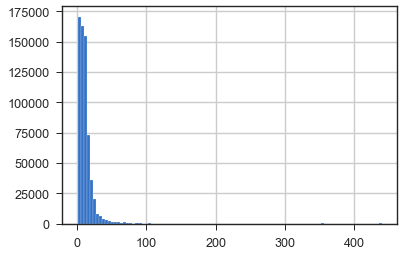

In [235]:
trees.block_count.hist(bins=100)

In [236]:
trees['log_block_count'] = trees.block_count.apply(lambda x: np.log(x))

In [239]:
trees.log_block_count.describe()

count    652173.000000
mean          2.178292
std           0.778604
min           0.000000
25%           1.609438
50%           2.197225
75%           2.708050
max           6.086775
Name: log_block_count, dtype: float64

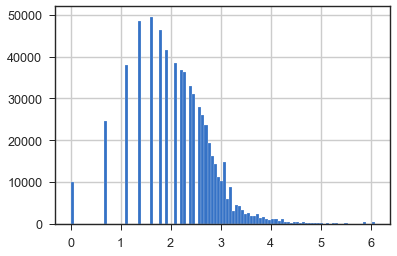

In [237]:
trees.log_block_count.hist(bins=100)

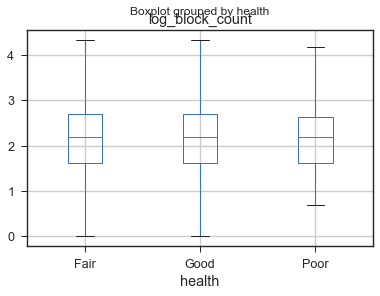

In [244]:
trees.boxplot('log_block_count', 'health', showfliers=False)

In [246]:
'''Distance equation for long,lat data used via stackoverflow from user Michael0x2a.
Updated to a function that converts to feet'''
# constant values, if need to change end lat, long points, change the lat2, lon2 information
lat2 = np.array(trees.latitude) #identifies iterable latitude column
lon2 = np.array(trees.longitude) #identifies iterable longitude column
latr = np.array(list(map(lambda x: np.radians(x), lat2)))
lonr = np.array(list(map(lambda x: np.radians(x), lon2)))

def distance(lat1,lon1):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = np.array(list(map(lambda x: (x - lon1), lonr)))
    dlat = np.array(list(map(lambda x: (x - lat1), latr)))
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # 6373.0 represents earth radius in kilometers
    kilo = 6373.0 * c
    feet = kilo * 3280.84
    return feet

In [ ]:
distance(40.723092, -73.844215)

* We want to build a model based on the professional entries, so let's drop all of the volunteer entries.

In [228]:
trees.user_type.value_counts()

TreesCount Staff    282259
Volunteer           207777
NYC Parks Staff     162137
Name: user_type, dtype: int64

In [10]:
# Get indices of volunteer
volunteers = trees[trees.user_type == 'Volunteer'].index
 
# Delete these row indices from dataFrame
trees.drop(volunteers, inplace=True)

trees.shape

(444396, 42)

* Look for NaN values.

In [11]:
trees.isna().sum()

created_at       0
tree_id          0
block_id         0
the_geom         0
tree_dbh         0
stump_diam       0
curb_loc         0
status           0
health           1
spc_latin        4
spc_common       4
steward          0
guards           1
sidewalk         1
user_type        0
problems        45
root_stone       0
root_grate       0
root_other       0
trunk_wire       0
trunk_light      0
trunk_other      0
branch_light     0
branch_shoe      0
branch_other     0
address          0
zipcode          0
zip_city         0
cb_num           0
borocode         0
boroname         0
council_dist     0
st_assem         0
st_senate        0
nta              0
nta_name         0
boro_ct          0
state            0
latitude         0
longitude        0
x_sp             0
y_sp             0
dtype: int64

* Replace NaNs in 'problems' column with 'None', in case we end up using that column.
* Drop the few rows with missing values for our target variable and species of tree.

In [12]:
trees.problems.fillna(value='None', inplace=True)

In [13]:
trees.dropna(how='any', axis=0, inplace=True)

* Create and pickle a dictionary of neighborhood codes and names, in case we want that later.

In [48]:
nta = list(trees['nta'].unique())

In [49]:
nta_name = list(trees['nta_name'].unique())

In [50]:
nta_dict = {k: v for k,v in zip(nta, nta_name)}

In [51]:
nta_dict

{'QN17': 'Forest Hills',
 'QN49': 'Whitestone',
 'BK90': 'East Williamsburg',
 'BK37': 'Park Slope-Gowanus',
 'MN14': 'Lincoln Square',
 'MN15': 'Clinton',
 'SI14': 'Grasmere-Arrochar-Ft. Wadsworth',
 'BK26': 'Gravesend',
 'QN72': 'Steinway',
 'SI54': 'Great Kills',
 'BK69': 'Clinton Hill',
 'BK81': 'Brownsville',
 'BK29': 'Bensonhurst East',
 'BK42': 'Flatbush',
 'QN25': 'Corona',
 'BK68': 'Fort Greene',
 'MN40': 'Upper East Side-Carnegie Hill',
 'MN12': 'Upper West Side',
 'SI25': 'Oakwood-Oakwood Beach',
 'QN60': 'Kew Gardens',
 'BK46': 'Ocean Parkway South',
 'MN27': 'Chinatown',
 'QN20': 'Ridgewood',
 'BX17': 'East Tremont',
 'SI36': 'Old Town-Dongan Hills-South Beach',
 'SI45': 'New Dorp-Midland Beach',
 'BK17': 'Sheepshead Bay-Gerritsen Beach-Manhattan Beach',
 'MN50': 'Stuyvesant Town-Cooper Village',
 'MN24': 'SoHo-TriBeCa-Civic Center-Little Italy',
 'SI24': 'Todt Hill-Emerson Hill-Heartland Village-Lighthous',
 'BK44': 'Madison',
 'QN62': 'Queensboro Hill',
 'SI01': "Annadal

In [17]:
# with open('data/nta_dict.pickle', 'wb') as f:
#     pickle.dump(nta_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

* Drop unnecessary columns and set index to each tree's unique ID.

In [18]:
trees.columns

Index(['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [19]:
drop_cols = ['created_at', 'block_id', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'user_type', 'problems',
             'address', 'zipcode', 'zip_city', 'borocode', 'council_dist', 'st_assem', 'st_senate', 'nta_name',
             'boro_ct', 'state', 'latitude', 'longitude', 'x_sp', 'y_sp']
trees.drop(columns=drop_cols, inplace=True)
trees.set_index(['tree_id'], inplace=True)
trees.shape

(444390, 19)

In [20]:
trees.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,branch_light,branch_shoe,branch_other,cb_num,boroname,nta
tree_id,,,,,,,,,,,,,,,,,,,
180683,3,OnCurb,Fair,red maple,None,None,NoDamage,No,No,No,No,No,No,No,No,No,406,Queens,QN17
200540,21,OnCurb,Fair,pin oak,None,None,Damage,Yes,No,No,No,No,No,No,No,No,407,Queens,QN49
209610,6,OnCurb,Good,honeylocust,None,None,NoDamage,No,No,No,No,No,No,No,No,No,502,Staten Island,SI14
192755,21,OffsetFromCurb,Fair,London planetree,None,None,NoDamage,No,No,No,No,No,No,No,No,No,313,Brooklyn,BK26
195202,13,OnCurb,Fair,London planetree,None,None,NoDamage,Yes,No,No,No,No,No,No,No,No,503,Staten Island,SI54


* Take a look at our target variable.

In [21]:
trees.health.value_counts()

Good    363591
Fair     63048
Poor     17751
Name: health, dtype: int64

In [22]:
trees.health.value_counts(normalize=True)

Good    0.818180
Fair    0.141875
Poor    0.039945
Name: health, dtype: float64

* Let's make a numeric column for our target variable, as this will help us with some of the statistical tests.

In [23]:
conditions = [
    trees.health == 'Good',
    trees.health == 'Fair'
]

choices = [
    2,
    1
]

trees['health_num'] = np.select(conditions, choices, 0)

* Since we only have one continuous variable (tree diameter), let's go ahead and rein in the extreme values on that now.

In [24]:
trees.tree_dbh.describe()

count    444390.000000
mean         11.908191
std           8.831671
min           0.000000
25%           5.000000
50%          10.000000
75%          17.000000
max         425.000000
Name: tree_dbh, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a530908>]],
      dtype=object)

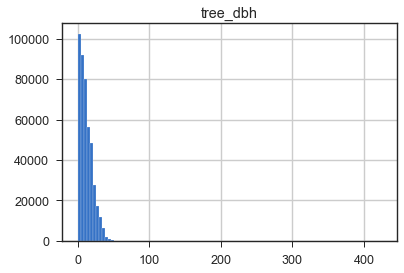

In [25]:
trees.hist('tree_dbh', bins=100)

In [26]:
trees[trees.tree_dbh == 425]

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,branch_light,branch_shoe,branch_other,cb_num,boroname,nta,health_num
tree_id,,,,,,,,,,,,,,,,,,,,
168583,425,OnCurb,Good,swamp white oak,1or2,None,Damage,No,No,No,No,No,No,No,No,No,308,Brooklyn,BK61,2


In [27]:
rein_extremes(trees, ['tree_dbh'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133918828>]],
      dtype=object)

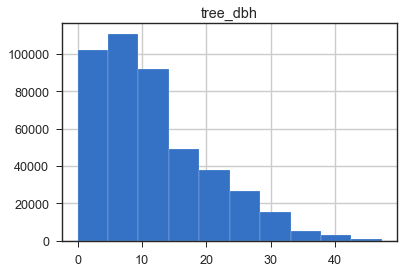

In [28]:
trees.hist('tree_dbh', bins=10)

### EDA - Boroughs

In [29]:
trees.boroname.value_counts()

Queens           164820
Staten Island     95733
Brooklyn          95101
Bronx             68082
Manhattan         20654
Name: boroname, dtype: int64

In [30]:
trees.groupby('boroname').health.value_counts()

boroname       health
Bronx          Good       57183
               Fair        8409
               Poor        2490
Brooklyn       Good       76921
               Fair       14375
               Poor        3805
Manhattan      Good       16084
               Fair        3420
               Poor        1150
Queens         Good      135189
               Fair       23364
               Poor        6267
Staten Island  Good       78214
               Fair       13480
               Poor        4039
Name: health, dtype: int64

In [31]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.839914
               Fair      0.123513
               Poor      0.036574
Brooklyn       Good      0.808835
               Fair      0.151155
               Poor      0.040010
Manhattan      Good      0.778735
               Fair      0.165585
               Poor      0.055679
Queens         Good      0.820222
               Fair      0.141755
               Poor      0.038023
Staten Island  Good      0.817001
               Fair      0.140808
               Poor      0.042190
Name: health, dtype: float64

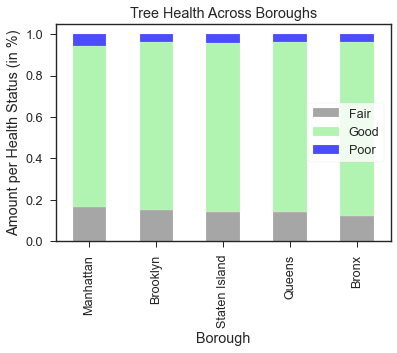

In [32]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack().sort_values('Good')
p1 = boros.plot(kind = 'bar', stacked = True, 
                   title = 'Tree Health Across Boroughs', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Borough')
p1.set_ylabel('Amount per Health Status (in %)')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

In [42]:
df_boro_health = pd.crosstab(trees.health, trees.boroname,
#                              normalize='index'
                            )
df_boro_health

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,8409,14375,3420,23364,13480
Good,57183,76921,16084,135189,78214
Poor,2490,3805,1150,6267,4039


In [43]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_boro_health)

In [44]:
stats.chi2_contingency(df_boro_health)

(566.5988905003828,
 3.530263683508544e-117,
 8,
 array([[  9659.15960305,  13492.49048808,   2930.29409303,
          23383.90008776,  13582.15572808],
        [ 55703.32919733,  77809.73399716,  16898.68924593,
         134852.42381692,  78326.82374266],
        [  2719.51119962,   3798.77551475,    825.01666104,
           6583.67609532,   3824.02052926]]))

In [45]:
# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(15.50731305586545, 566.5988905003828)

In [49]:
import statsmodels.api as sm 

table = sm.stats.Table(df_boro_health)
table.standardized_resids

boroname,Bronx,Brooklyn,Manhattan,Queens,Staten Island
health,,,,,
Fair,-14.922137,9.250982,10.000898,-0.177116,-1.068283
Good,15.977694,-8.427983,-15.051476,2.710004,-1.067351
Poor,-4.881134,0.116258,11.825406,-5.021920,4.005638


In [90]:
abs_table = table.standardized_resids.apply(lambda x: abs(x))
abs_table[abs_table > 1.96].count().sum() / abs_table.count().sum()

0.7333333333333333

In [ ]:
please break my clode

### EDA - Tree diameter

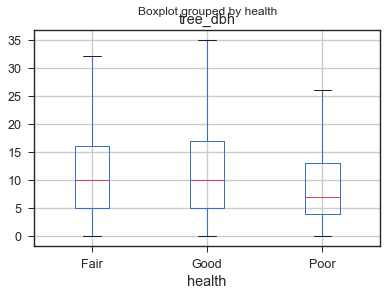

In [78]:
trees.boxplot('tree_dbh', 'health', showfliers=False)

### EDA - Community Boards

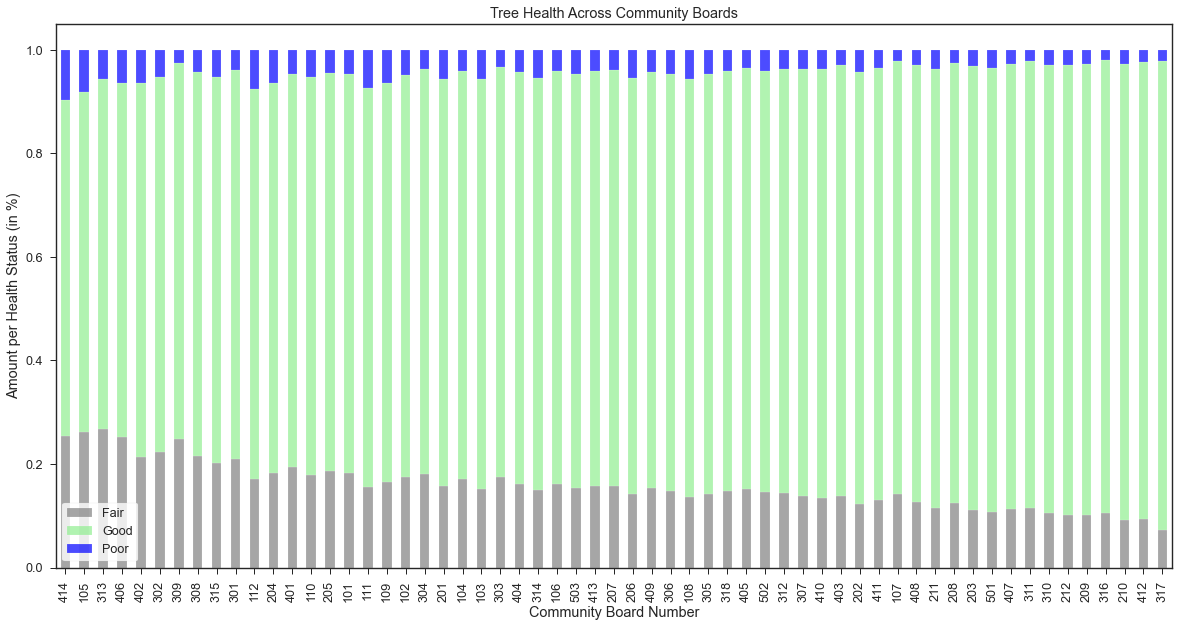

In [79]:
community_boards = trees.groupby(['cb_num']).health.value_counts(normalize=True).unstack().sort_values('Good')
p2 = community_boards.plot(kind = 'bar', stacked = True, figsize=(20,10),
                   title = 'Tree Health Across Community Boards', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p2.set_xlabel('Community Board Number')
p2.set_ylabel('Amount per Health Status (in %)')
p2.legend(['Fair','Good', 'Poor'])
plt.show()

In [52]:
df_cb_health = pd.crosstab(trees.health, trees.cb_num,
#                              normalize='index'
                            )
df_cb_health

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,344,316,232,154,151,198,253,282,296,375,...,1940,1019,1780,2715,2082,4997,2438,2518,3291,7671
Good,1446,1395,1212,710,377,977,1495,1676,1375,1619,...,12952,5343,10898,17499,19767,25522,6231,20231,18306,39677
Poor,89,86,85,36,47,51,40,115,113,111,...,438,278,485,719,541,1314,933,809,910,2320


In [56]:
# returns 𝜒2 value, p-value, degree of freedom and expected values
stat, p, dof, expected = stats.chi2_contingency(df_cb_health)

# print(stats.chi2_contingency(df_cb_health))

# interpret test-statistic
prob = 0.95
critical = stats.chi2.ppf(prob, dof)
critical, stat

(142.13816003902645, 7345.570039622511)

In [54]:
table2 = sm.stats.Table(df_cb_health)
table2.standardized_resids

cb_num,101,102,103,104,105,106,107,108,109,110,...,408,409,410,411,412,413,414,501,502,503
health,,,,,,,,,,,,,,,,,,,,,
Fair,5.129318,4.135827,1.106630,2.516209,8.302588,1.972131,-0.045719,-0.763919,2.916401,4.780778,...,-5.534750,2.726784,-2.219009,-5.172068,-21.514019,8.013637,31.807539,-15.816677,1.917722,8.518952
Good,-5.476062,-4.612954,-2.590196,-2.280614,-10.111078,-1.934466,1.971846,-1.146535,-5.205602,-5.849639,...,8.722672,-2.876107,2.943221,6.829744,25.745851,-7.889693,-43.472485,16.600254,-1.929381,-11.854639
Poor,1.646141,1.716374,3.129772,0.008489,5.121022,0.296153,-3.802197,3.619290,5.056362,3.002939,...,-7.318128,0.806150,-1.843072,-4.236120,-12.374838,1.260728,28.947729,-4.513437,0.383085,8.169549


In [92]:
abs_table2 = table2.standardized_resids.apply(lambda x: abs(x))
abs_table2[abs_table2 > 1.96].count().sum() / abs_table2.count().sum()

0.7570621468926554

### EDA - Neighborhoods

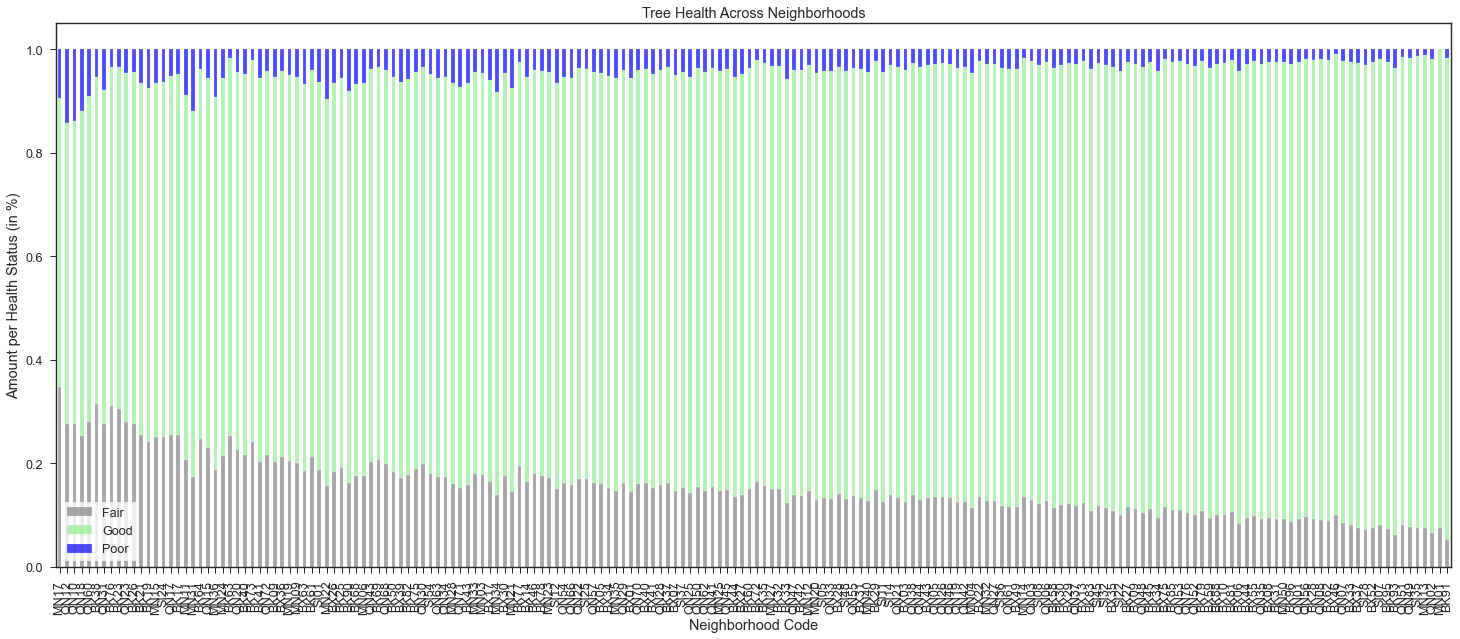

In [67]:
neighborhoods = trees.groupby(['nta']).health.value_counts(normalize=True).unstack().sort_values('Good')
p3 = neighborhoods.plot(kind = 'bar', stacked = True, figsize=(25,10),
                   title = 'Tree Health Across Neighborhoods', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p3.set_xlabel('Neighborhood Code')
p3.set_ylabel('Amount per Health Status (in %)')
p3.legend(['Fair','Good', 'Poor'])
plt.show()

In [70]:
df_nta_health = pd.crosstab(trees.health, trees.nta,
#                              normalize='columns'
                        )
df_nta_health

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,30,1132,182,314,136,675,215,151,187,296,...,959,668,214,1008,238,560,521,519,880,1782
Good,110,3082,514,839,295,2672,529,1116,1809,1655,...,2618,3134,2681,7563,2861,4035,2737,3764,5521,7685
Poor,8,215,57,81,15,197,35,32,41,45,...,241,150,92,271,40,175,148,119,275,482


In [71]:
table3 = sm.stats.Table(df_nta_health)
table3.standardized_resids

nta,BK09,BK17,BK19,BK21,BK23,BK25,BK26,BK27,BK28,BK29,...,SI24,SI25,SI28,SI32,SI35,SI36,SI37,SI45,SI48,SI54
health,,,,,,,,,,,,,,,,,,,,,
Fair,2.121165,21.797632,7.857331,11.350140,9.874106,8.323038,10.737758,-2.651511,-6.491918,0.824057,...,19.440027,4.914049,-11.037866,-7.587663,-10.644162,-4.870721,1.862093,-4.581456,-2.373582,10.766321
Good,-2.363995,-21.210308,-9.653901,-12.611392,-8.586783,-9.953336,-10.074908,3.831576,8.197327,1.274632,...,-21.315473,-4.119667,11.285759,9.153572,13.594823,4.992886,-2.217250,6.376933,1.881180,-11.963350
Poor,0.876589,2.936571,5.013913,4.615492,-0.681190,4.773887,0.710913,-2.822096,-4.577958,-3.978687,...,7.344349,-0.641763,-2.561007,-4.508978,-7.810264,-1.155269,1.049172,-4.396590,0.524073,4.379370


In [94]:
abs_table3 = table3.standardized_resids.apply(lambda x: abs(x))
abs_table3[abs_table3 > 1.96].count().sum() / abs_table3.count().sum()

0.6897163120567376

### EDA - Tree species

In [72]:
print(f'Number of unique species: {len(trees.spc_common.unique())}')
print(f'Number of total trees: {len(trees)}')
print(f'Cutoff for trees of significant quantity (0.1% of total trees): {np.ceil(len(trees)/1000)}')

Number of unique species: 132
Number of total trees: 444390
Cutoff for trees of significant quantity (0.1% of total trees): 445.0


In [73]:
# create a column with the total count of that row's tree species
species_counts = trees['spc_common'].value_counts().rename('species_counts')

# merge onto dataframe
trees = trees.merge(species_counts.to_frame(),
                                left_on='spc_common',
                                right_index=True)

# reassign tree species with fewer than 445 datapoints to 'Other'
trees['spc_common'] = np.where(trees.species_counts < 445, 'Other', trees.spc_common)

trees.spc_common.value_counts().head(20)

London planetree     60350
Callery pear         42487
honeylocust          38349
pin oak              35985
Norway maple         25253
cherry               22772
Japanese zelkova     18928
littleleaf linden    18469
red maple            13906
ginkgo               11355
green ash            10572
Sophora              10440
silver maple         10081
Other                 9918
American linden       8399
sweetgum              8380
purple-leaf plum      5281
maple                 5211
American elm          5192
northern red oak      5153
Name: spc_common, dtype: int64

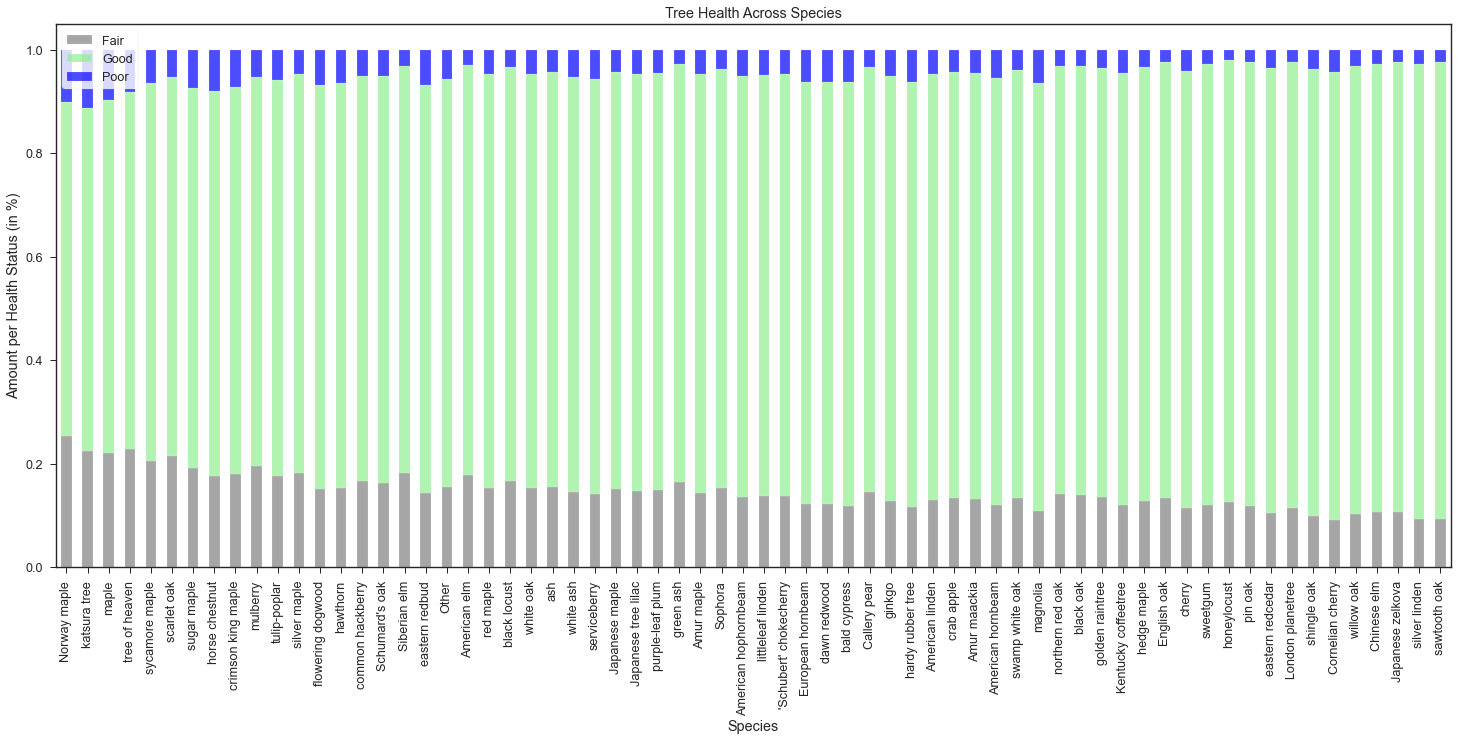

In [74]:
spc = trees.groupby(['spc_common']).health.value_counts(normalize=True).unstack().sort_values('Good')
p4 = spc.plot(kind = 'bar', stacked = True, figsize=(25,10),
                   title = 'Tree Health Across Species', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p4.set_xlabel('Species')
p4.set_ylabel('Amount per Health Status (in %)')
p4.legend(['Fair','Good', 'Poor'])
plt.show()

In [80]:
df_spc_health = pd.crosstab(trees.health, trees.spc_common,
#                              normalize='columns'
                        )
df_spc_health

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,442,926,93,140,1099,225,237,6216,304,65,...,1843,350,568,1017,405,106,129,130,175,210
Good,2606,4110,559,954,6913,1412,1342,34820,2444,608,...,7771,1345,3473,7125,1433,321,560,712,916,1761
Poor,151,156,35,63,387,77,79,1451,77,30,...,467,134,167,238,126,38,43,46,54,65


In [82]:
table4 = sm.stats.Table(df_spc_health)
table4.standardized_resids

spc_common,'Schubert' chokecherry,American elm,American hophornbeam,American hornbeam,American linden,Amur maackia,Amur maple,Callery pear,Chinese elm,Cornelian cherry,...,silver maple,sugar maple,swamp white oak,sweetgum,sycamore maple,tree of heaven,tulip-poplar,white ash,white oak,willow oak
health,,,,,,,,,,,,,,,,,,,,,
Fair,-0.603106,7.576995,-0.488967,-2.037439,-2.923916,-1.260565,0.124858,2.750728,-5.236162,-3.757917,...,11.917738,6.077938,-1.287867,-5.433738,8.189565,5.322743,2.666022,0.386499,1.064549,-5.020267
Good,-0.522527,-4.994458,-0.305859,0.562176,1.174069,0.604845,-0.927706,0.766975,6.490975,3.211830,...,-12.461487,-9.200599,1.208732,7.681683,-10.196686,-7.152113,-3.731584,-1.266663,-1.597022,5.481938
Poor,2.103740,-3.663597,1.473631,2.523008,2.897351,1.054760,1.604699,-6.411759,-3.454697,0.369866,...,3.308921,7.291597,-0.085981,-5.447825,5.491013,4.602577,2.599321,1.806109,1.248642,-1.852017


In [95]:
abs_table4 = table4.standardized_resids.apply(lambda x: abs(x))
abs_table4[abs_table4 > 1.96].count().sum() / abs_table4.count().sum()

0.6212121212121212

In [96]:
trees.drop(columns='species_counts', axis=1, inplace=True)

In [ ]:
# trees.to_csv('data/nyc_trees_2015_pre_dummies.csv')

### Dummy columns

In [124]:
trees = pd.read_csv('data/nyc_trees_2015_pre_dummies.csv', index_col=0)

In [125]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'boroname', 'nta', 'health_num'],
      dtype='object')

In [126]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [127]:
trees.sidewalk.unique()

array(['NoDamage', 'Damage'], dtype=object)

In [128]:
# rename columns that we have to manually dummy, so the new 0 and 1 values make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)

* Reassign yes-no columns to 1s and 0s.

In [129]:
trees.branch_other.unique()

array(['No', 'Yes'], dtype=object)

In [130]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

array([0, 1])

In [ ]:
yes_no_cols.extend(['on_curb', 'sidewalk_damage'])

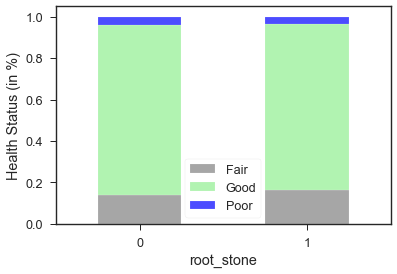

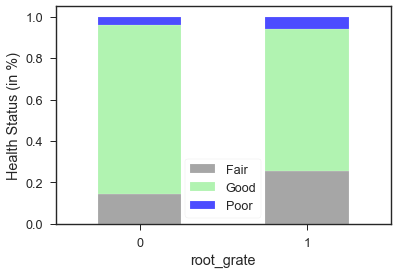

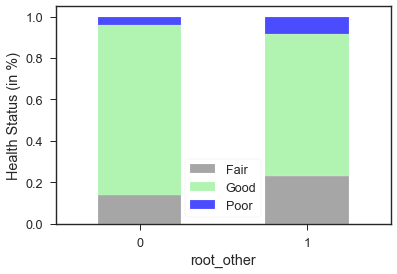

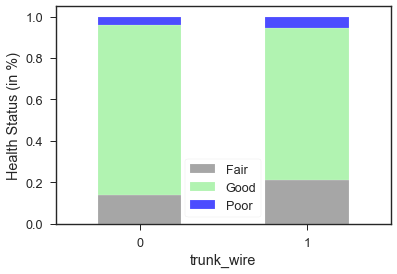

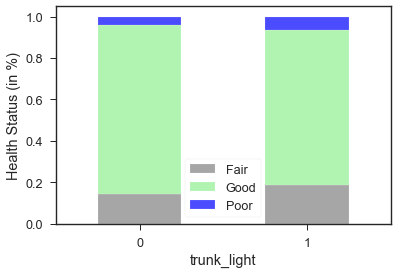

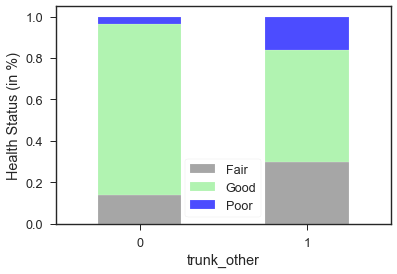

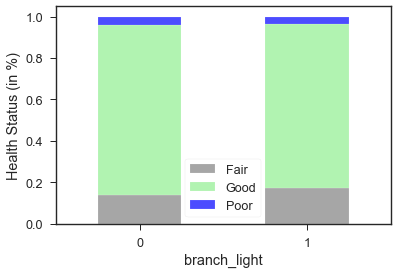

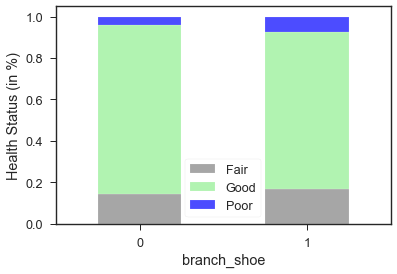

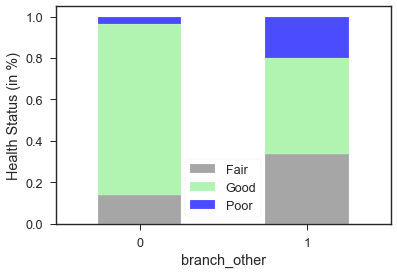

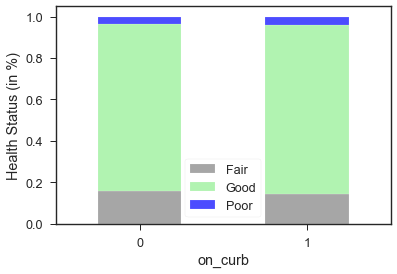

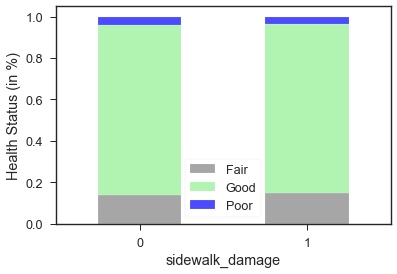

In [131]:
for col in yes_no_cols:
    grouped = trees.groupby(col).health.value_counts(normalize=True).unstack()
    ax = grouped.plot(kind = 'bar', stacked = True, 
#                        title = f'', 
                       color = ['grey','lightgreen', 'blue'], alpha = .70)
    ax.set_xticklabels([0,1], rotation=0)
    ax.set_xlabel(col)
    ax.set_ylabel('Health Status (in %)')
    ax.legend(['Fair','Good', 'Poor'])

* First rename a steward value that doesn't make sense (4 is accounted for twice, so renaming '4orMore' to '5plus').
* Create dummies for number of stewards, usefulness of tree guards, and borough name.
* Hold off on creating dummies for community board numbers and neighborhood codes.

In [138]:
trees.groupby('sidewalk_damage').health.value_counts(normalize=True)

sidewalk_damage  health
0                Good      0.817650
                 Fair      0.140437
                 Poor      0.041912
1                Good      0.819675
                 Fair      0.145936
                 Poor      0.034389
Name: health, dtype: float64

In [139]:
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

In [140]:
trees.steward.unique()

array(['None', '1or2', '3or4', '5plus'], dtype=object)

In [141]:
trees.groupby('steward').health.value_counts(normalize=True)

steward  health
1or2     Good      0.811771
         Fair      0.146373
         Poor      0.041856
3or4     Good      0.828384
         Fair      0.133413
         Poor      0.038203
5plus    Good      0.833811
         Fair      0.133238
         Poor      0.032951
None     Good      0.819346
         Fair      0.141077
         Poor      0.039577
Name: health, dtype: float64

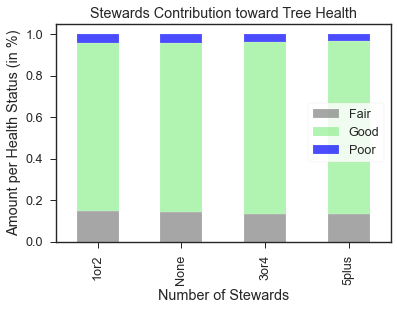

In [142]:
stewards = trees.groupby(['steward']).health.value_counts(normalize=True).unstack().sort_values('Good')
p5 = stewards.plot(kind = 'bar', stacked = True, 
                   title = 'Stewards Contribution toward Tree Health', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p5.set_xlabel('Number of Stewards')
p5.set_ylabel('Amount per Health Status (in %)')
p5.legend(['Fair','Good', 'Poor'])
plt.show()

In [143]:
trees.guards.value_counts()

None       413018
Helpful     21896
Harmful      6222
Unsure       3254
Name: guards, dtype: int64

In [144]:
trees.groupby('guards').health.value_counts(normalize=True)

guards   health
Harmful  Good      0.763581
         Fair      0.183864
         Poor      0.052555
Helpful  Good      0.831339
         Fair      0.129156
         Poor      0.039505
None     Good      0.818657
         Fair      0.141691
         Poor      0.039652
Unsure   Good      0.773510
         Fair      0.170559
         Poor      0.055931
Name: health, dtype: float64

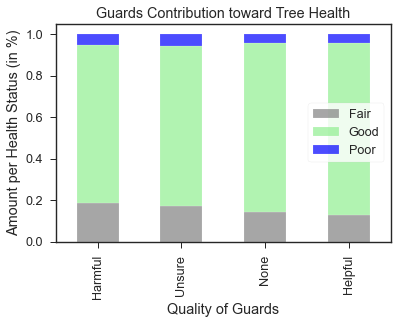

In [145]:
guards = trees.groupby(['guards']).health.value_counts(normalize=True).unstack().sort_values('Good')
p6 = guards.plot(kind = 'bar', stacked = True, 
                   title = 'Guards Contribution toward Tree Health', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p6.set_xlabel('Quality of Guards')
p6.set_ylabel('Amount per Health Status (in %)')
p6.legend(['Fair','Good', 'Poor'])
plt.show()

In [146]:
dummy_cols = ['steward', 'guards', 'boroname', 'cb_num', 'spc_common',
#               'nta'
             ]

trees['cb_num'] = trees.cb_num.astype(str)

In [147]:
tree_dummies = pd.get_dummies(trees[dummy_cols])
tree_dummies.columns = [col.replace(' ', '_').replace("'", "") for col in list(tree_dummies.columns)]
tree_dummies.columns

Index(['steward_1or2', 'steward_3or4', 'steward_5plus', 'steward_None',
       'guards_Harmful', 'guards_Helpful', 'guards_None', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn',
       ...
       'spc_common_silver_maple', 'spc_common_sugar_maple',
       'spc_common_swamp_white_oak', 'spc_common_sweetgum',
       'spc_common_sycamore_maple', 'spc_common_tree_of_heaven',
       'spc_common_tulip-poplar', 'spc_common_white_ash',
       'spc_common_white_oak', 'spc_common_willow_oak'],
      dtype='object', length=138)

In [148]:
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten_Island', 'nta'])
trees_full = pd.concat([trees,tree_dummies], axis=1)
trees_full.drop(columns=dummy_cols, axis=1, inplace=True)

In [149]:
trees_full.columns

Index(['tree_dbh', 'on_curb', 'health', 'sidewalk_damage', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       ...
       'spc_common_silver_maple', 'spc_common_sugar_maple',
       'spc_common_swamp_white_oak', 'spc_common_sweetgum',
       'spc_common_sycamore_maple', 'spc_common_tree_of_heaven',
       'spc_common_tulip-poplar', 'spc_common_white_ash',
       'spc_common_white_oak', 'spc_common_willow_oak'],
      dtype='object', length=149)

In [150]:
trees_full.head()

,tree_dbh,on_curb,health,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,...,spc_common_silver_maple,spc_common_sugar_maple,spc_common_swamp_white_oak,spc_common_sweetgum,spc_common_sycamore_maple,spc_common_tree_of_heaven,spc_common_tulip-poplar,spc_common_white_ash,spc_common_white_oak,spc_common_willow_oak
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,Fair,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184031,3.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208974,10.0,1,Good,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198146,6.0,1,Good,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198230,10.0,1,Good,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [158]:
X = trees_full.drop(columns=['health', 'health_num'], axis=1)
y = trees_full['health_num']

In [159]:
X.head()

,tree_dbh,on_curb,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,branch_light,...,spc_common_silver_maple,spc_common_sugar_maple,spc_common_swamp_white_oak,spc_common_sweetgum,spc_common_sycamore_maple,spc_common_tree_of_heaven,spc_common_tulip-poplar,spc_common_white_ash,spc_common_white_oak,spc_common_willow_oak
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184031,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208974,10.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198146,6.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198230,10.0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [160]:
X_sm = sm.add_constant(X)
est = sm.OLS(y, X_sm)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     243.3
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:26:42   Log-Likelihood:            -3.0820e+05
No. Observations:              444390   AIC:                         6.167e+05
Df Residuals:                  444248   BIC:                         6.182e+05
Df Model:                         141                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [161]:
p = est2.pvalues
high_p = p[p > .05].keys()

X_simp = X.drop(columns=high_p)

X_simp.head()

,tree_dbh,on_curb,sidewalk_damage,root_stone,root_grate,root_other,trunk_wire,trunk_other,branch_light,branch_other,...,spc_common_shingle_oak,spc_common_silver_linden,spc_common_silver_maple,spc_common_sugar_maple,spc_common_swamp_white_oak,spc_common_sweetgum,spc_common_sycamore_maple,spc_common_tree_of_heaven,spc_common_tulip-poplar,spc_common_willow_oak
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
184031,3.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
208974,10.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198146,6.0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198230,10.0,1,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
X_sm2 = sm.add_constant(X_simp)
est = sm.OLS(y, X_sm2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     278.7
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:27:04   Log-Likelihood:            -3.0821e+05
No. Observations:              444390   AIC:                         6.167e+05
Df Residuals:                  444266   BIC:                         6.180e+05
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [163]:
p2 = est2.pvalues
high_p2 = p2[p2 > .05].keys()

X_simp2 = X_simp.drop(columns=high_p2)

X_sm3 = sm.add_constant(X_simp2)
est = sm.OLS(y, X_sm3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     303.2
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:28:25   Log-Likelihood:            -3.0822e+05
No. Observations:              444390   AIC:                         6.167e+05
Df Residuals:                  444276   BIC:                         6.179e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [167]:
p3 = est2.pvalues
high_p3 = p3[p3 > .05].keys()

X_simp3 = X_simp2.drop(columns=high_p3)

X_sm4 = sm.add_constant(X_simp3)
est = sm.OLS(y, X_sm4)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             health_num   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     308.6
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        18:32:46   Log-Likelihood:            -3.0822e+05
No. Observations:              444390   AIC:                         6.167e+05
Df Residuals:                  444278   BIC:                         6.179e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

## SAVE A COPY

In [ ]:
trees_full.to_csv('data/nyc_trees_2015.csv')

In [ ]:
trees_full = pd.read_csv('data/nyc_trees_2015.csv', index_col=0)
trees_full.head()

In [ ]:
please break this code

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = trees_full.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr_matrix = trees_full.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

sol[sol > .8]

In [ ]:
sol[sol > .6]

## Vanilla models

In [168]:
X_van = trees_full.drop(columns=['health', 'health_num'], axis=1)
y_van = trees_full['health']

In [169]:
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

### Resample

In [170]:
# concatenate our training data back together
training  = pd.concat([X_train_van, y_train_van], axis=1)

In [171]:
# separate minority and majority classes
good = training[training.health=='Good']
fair = training[training.health=='Fair']
poor = training[training.health=='Poor']

In [172]:
# Get a class count to understand the class imbalance.
print('good count: '+ str(len(good)))
print('fair count: '+ str(len(fair)))
print('poor count: '+ str(len(poor)))

good count: 272693
fair count: 47286
poor count: 13313


In [173]:
# downsample majority
good_downsampled = resample(good,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

# downsample majority
fair_downsampled = resample(fair,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

In [174]:
# combine minority and downsampled majority
downsampled = pd.concat([good_downsampled, fair_downsampled, poor])

# checking counts
downsampled.health.value_counts()

Good    13313
Fair    13313
Poor    13313
Name: health, dtype: int64

In [175]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.health
X_train_down = downsampled.drop('health', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(class_weight='balanced', multi_class='multinomial', random_state=42, n_jobs=-1)


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, downsampled_pred))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, downsampled_pred, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, downsampled_pred, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, downsampled_pred, average='weighted'))

Test Accuracy score:  0.5456983924103044
Test F1 score:  0.6185737140646788
Test Recall score:  0.5456983924103044
Test Precision score:  0.747739638364124


In [176]:
# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_forest = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)


# downsampled_dt.fit(X_train, y_train)
downsampled_forest.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred_forest = downsampled_forest.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, downsampled_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, downsampled_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, downsampled_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, downsampled_pred_forest, average='weighted'))

Test Accuracy score:  0.4731318295558876
Test F1 score:  0.5549283766743528
Test Recall score:  0.4731318295558876
Test Precision score:  0.7555963095878665


In [177]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 8, n_estimators = 250, 
                             min_samples_leaf = 8, min_samples_split = 2, random_state = 23, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train_down, y_train_down)

#Predict the response for test dataset
y_pred_forest_van = ant_forest.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_forest_van))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, y_pred_forest_van, average='weighted'))

Test Accuracy score:  0.5780662118129939
Test F1 score:  0.6412392465286704
Test Recall score:  0.5780662118129939
Test Precision score:  0.7456297682460449


In [178]:
ant_forest = RandomForestClassifier(criterion = 'entropy', max_depth = 8, n_estimators = 250, 
                             min_samples_leaf = 8, min_samples_split = 2, random_state = 23, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest.fit(X_train_van, y_train_van)

#Predict the response for test dataset
y_pred_forest_van = ant_forest.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_forest_van))

# checking f1
print('Test F1 score: ', f1_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van, y_pred_forest_van, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van, y_pred_forest_van, average='weighted'))

Test Accuracy score:  0.6026571135393977
Test F1 score:  0.6572653221291723
Test Recall score:  0.6026571135393977
Test Precision score:  0.7455087800499963


In [179]:
X_van_fewer = X_simp.copy()
y_van_fewer = trees_full['health']

In [181]:
X_train_van_fewer, X_test_van_fewer, y_train_van_fewer, y_test_van_fewer = train_test_split(
                                                                            X_van_fewer, y_van_fewer,
                                                                            random_state=42, stratify=y_van_fewer)

In [209]:
ant_forest_fewer = RandomForestClassifier(criterion = 'gini', max_depth = 8, n_estimators = 100, 
                             min_samples_leaf = 6, min_samples_split = 2, random_state = 42, 
                             class_weight='balanced', bootstrap=True, n_jobs=-1)

ant_forest_fewer.fit(X_train_van_fewer, y_train_van_fewer)

#Predict the response for test dataset
y_pred_forest_van_fewer = ant_forest_fewer.predict(X_test_van_fewer)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van_fewer, y_pred_forest_van_fewer))

# checking f1
print('Test F1 score: ', f1_score(y_test_van_fewer, y_pred_forest_van_fewer, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van_fewer, y_pred_forest_van_fewer, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van_fewer, y_pred_forest_van_fewer, average='weighted'))

Test Accuracy score:  0.6231615330609012
Test F1 score:  0.6677490516969682
Test Recall score:  0.6231615330609012
Test Precision score:  0.7426988033102823


In [210]:
#create a dictionary of all the parameters you want to tune
params_forest = {
    'max_depth': range(5,16),
#     'max_features': range(12,19),
#     'min_samples_split': range(1,10),
    'min_samples_leaf': range(5,16),
}

In [212]:
#create a grid search object and fit it to the data
forest = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=2)
CV_forest = GridSearchCV(forest, params_forest, scoring='accuracy', n_jobs=-1, verbose=2)
CV_forest.fit(X_train_van_fewer, y_train_van_fewer)

Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 605 out of 605 | elapsed: 59.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100building tree 6 of 100building tree 7 of 100





building tree 8 of 100

building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100building tree 31 of 100

building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100building tree 43 of 100
building tree 44 of 100building tree 45 of 100


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100building tree 63 of 100building tree 64 of 100


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                           

In [213]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print(CV_forest.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(CV_forest.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(CV_forest.best_estimator_)

0.6519718998084731
{'max_depth': 5, 'min_samples_leaf': 9}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=2,
                       warm_start=False)


In [214]:
#Predict the response for test dataset
y_pred_forest = CV_forest.best_estimator_.predict(X_test_van_fewer)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van_fewer, y_pred_forest))

# checking f1
print('Test F1 score: ', f1_score(y_test_van_fewer, y_pred_forest, average='weighted'))

# checking recall
print('Test Recall score: ', recall_score(y_test_van_fewer, y_pred_forest, average='weighted'))

# checking precision
print('Test Precision score: ', precision_score(y_test_van_fewer, y_pred_forest, average='weighted'))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Test Accuracy score:  0.6663486291382383
Test F1 score:  0.6898248400612801
Test Recall score:  0.6663486291382383
Test Precision score:  0.7376301399595175


In [218]:
with open('data/best_model_0526.pickle', 'wb') as f:
    pickle.dump(CV_forest.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [215]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_van_fewer, y_pred_forest)
classes = ['Fair', 'Good', 'Poor']

In [216]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[ 1181  9622  4959]
 [ 3708 70813 16377]
 [  255  2147  2036]]


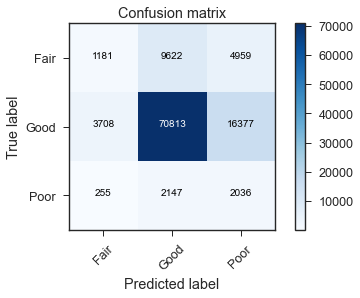

In [217]:
import itertools
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
import math

_REPLACE = 'replace'
_DROP = 'drop'
_DROP_SAMPLES = 'drop_samples'
_DROP_FEATURES = 'drop_features'
_SKIP = 'skip'
_DEFAULT_REPLACE_VALUE = 0.0

def conditional_entropy(x,
                        y,
                        nan_strategy=_REPLACE,
                        nan_replace_value=_DEFAULT_REPLACE_VALUE,
                        log_base: float = math.e):

    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

In [ ]:
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = stats.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:
theils_u(trees_full, trees_full)

In [ ]:
# params_knn = {
#     'n_neighbors': range(1,21,2),
#     'weights': ['uniform', 'distance'],
# #     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#     'p': range(1,4)
# }

In [ ]:
# CV_knn_van = GridSearchCV(KNeighborsClassifier(), params_knn, n_jobs=-1, scoring='accuracy', verbose=1)

# CV_knn_van.fit(X_train_van, y_train_van)

In [ ]:
# ### Identify the best params 
# print(CV_knn_van.best_estimator_)

# #Identify the best score during fitting with cross-validation
# print(CV_knn_van.best_score_)

In [ ]:
# #predict on the test set
# y_pred_knn_van = CV_knn_van.best_estimator_.predict(X_test_van)

# # checking metrics
# print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_knn_van))
# print('Test Precision score: ', precision_score(y_test_van, y_pred_knn_van))
# print('Test Recall score: ', recall_score(y_test_van, y_pred_knn_van))
# print('Test F1 score: ', f1_score(y_test_van, y_pred_knn_van))

In [ ]:
param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.0001, .001, .01, .1, 1.0, 10.0, 100.0],
    'solver': ['sag', 'saga', 'liblinear'],
}

In [ ]:
van_weight = LogisticRegression(class_weight='balanced', multi_class='multinomial')
van_weight.fit(X_train_van, y_train_van)

#predict on the test set
y_pred_van_weight = van_weight.predict(X_test_van)

In [ ]:
# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight, average='weighted'))

In [ ]:
#create a grid search object and fit it to the data
CV_van_weight = GridSearchCV(LogisticRegression(class_weight='balanced'),
                      param_grid, n_jobs=-1, scoring='accuracy', verbose=2)

CV_van_weight.fit(X_train_van, y_train_van)

In [ ]:
### Identify the best params 
print(CV_van_weight.best_estimator_)

#Identify the best score during fitting with cross-validation
print(CV_van_weight.best_score_)

In [ ]:
#predict on the test set
y_pred_van_weight = CV_van_weight.best_estimator_.predict(X_test_van)

# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight))

In [ ]:
trees[trees.nta == 'QN17'].iloc[:, 10:].head()

In [ ]:
print(len(trees.cb_num.unique()))
trees.cb_num.unique()

In [ ]:
print(len(trees.nta.unique()))
trees.nta.unique()

In [ ]:
trees.iloc[:, 10:].head(10)

In [ ]:
trees.spc_common.value_counts().head(10).keys()

In [ ]:
trees_most_pop = trees[trees.spc_common.isin(['London planetree', 'honeylocust', 'Callery pear', 'pin oak',
       'Norway maple', 'littleleaf linden', 'cherry', 'Japanese zelkova',
       'ginkgo', 'Sophora'])]
trees_most_pop.head()

In [ ]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack()

In [ ]:
# print('Paycode 1 Summary')

# print('\n')
# print(df_train.groupby(['pay_1_bin','default']).pay_1_bin.count().unstack())

# Passenger class visualization
species_health = trees_most_pop.groupby('spc_common').health.value_counts(normalize=True).unstack().head(10)
p1 = species_health.plot(kind = 'bar', stacked = True, 
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Paycode 1')
p1.set_ylabel('# Users')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

In [ ]:
trees[trees.spc_common == 'London planetree'].health.value_counts(normalize=True)

In [ ]:
trees.groupby('spc_common').health.value_counts(normalize=True)

In [ ]:
trees.columns

In [ ]:
trees.trunk_light.unique()

In [ ]:
trees.problems.value_counts()

In [ ]:
trees.shape

In [ ]:
trees.columns

In [ ]:
len(trees.council_dist.unique())

In [ ]:
len(trees.tree_dbh.unique())

In [ ]:
len(trees.block_id.unique())

In [ ]:
trees.health.value_counts()

In [ ]:
trees.health.value_counts(normalize=True)

In [ ]:
trees.health.isna().sum()

In [ ]:
trees.status.value_counts()

In [ ]:
trees[trees.health.isna()].head(20)

In [ ]:
trees.columns

In [ ]:
trees.curb_loc.unique()

In [ ]:
trees.borocode.value_counts()

In [ ]:
trees.drop(columns=['status'], axis=1)